# Semantic Segmentation of aerial satellite images

## Dataset
The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:

1. Building: #3C1098
2. Land (unpaved area): #8429F6
3. Road: #6EC1E4
4. Vegetation: #FEDD3A
5. Water: #E2A929
6. Unlabeled: #9B9B9B

## Preprocessing pipeline

- Images come in many sizes: 797x644, 509x544, 682x658, 1099x846, 1126x1058, etc.
- Need to preprocess so we can capture all images into numpy arrays. ​
- Crop to a size divisible by 256 and extract patches.​
- ​Masks are RGB and information provided as HEX color code.​
- Need to convert HEX to RGB values and then convert RGB labels to integer values and then to one hot encoded. ​
- ​Predicted (segmented) images need to converted back into original RGB colors. ​


In [2]:
# import libraries

import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

Segmentation Models: using `keras` framework.


In [3]:
# define root directory
root_dir = 'Semantic segmentation dataset/'

# define patch size
patch_size = 256

In [4]:
# load images
image_dataset = []
for path, subdirs, files in os.walk(root_dir):
    # print(files) # print(path) # print(subdirs)
    dirname = path.split(os.path.sep)[-1]
    # print(dirname)

    if dirname == 'images': #find all image directories
        images = os.listdir(path) #list of all image names in subdir
        # print(images)

        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"): # find images ending with .jpg
                # read each image
                image = cv2.imread(path+"/"+image_name, 1)

                # get x and y dimensions rounded to multiples of 256
                SIZE_X = (image.shape[1]//patch_size) * patch_size 
                SIZE_Y = (image.shape[0]//patch_size) * patch_size 
                image = Image.fromarray(image)

                # crop the image
                image = image.crop((0,0,SIZE_X, SIZE_Y))
                image = np.array(image)

                # Extract patches from each image
                # print("Now patchifying image", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img) 

In [5]:
# Now do the same as above for masks
mask_dataset = []  
for path, subdirs, files in os.walk(root_dir):

    dirname = path.split(os.path.sep)[-1]

    if dirname == 'masks':   
        masks = os.listdir(path)  
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):  
               
                mask = cv2.imread(path+"/"+mask_name, 1)  
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size 
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size 
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  
                mask = np.array(mask)             
    
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size) 
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]                          
                        mask_dataset.append(single_patch_mask)

In [7]:
# convert python array to numpy array
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

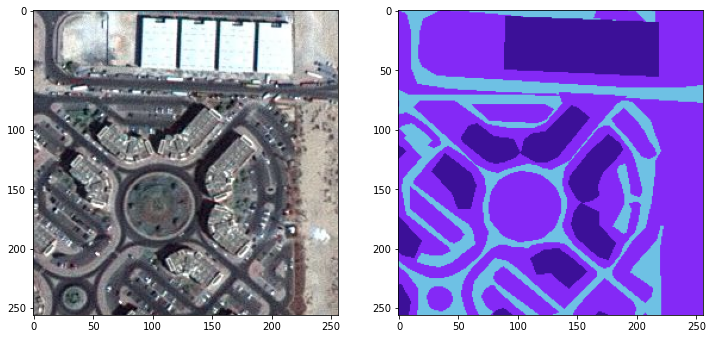

In [8]:
#Sanity check 
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

### Converting RGB hex values into (R, G, B) np array

In [9]:
# Convert hex value to rgb in a form of np array for class building
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4)))
print("RGB values of:", Building)

RGB values of: [ 60  16 152]


In [10]:
# Do the same for class land
Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4)))

# Do the same for the other classes
Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 15

In [15]:
# Now replace RGB to integer values to be used as labels.
# Find pixels with combination of RGB for the above defined arrays...
# If matches then replace all values in that pixel with a specific integer
label = single_patch_mask

def rgb_to_2D_label(label):
    
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label==Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

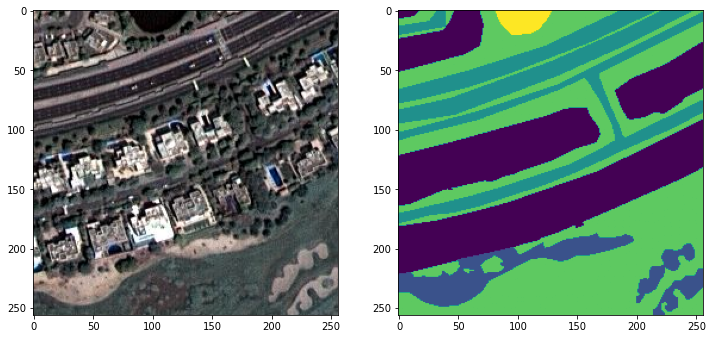

In [18]:
# Sanity check
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

# DEEP LEARNING MODEL

Using Standard Unett Model to train the machine to predict an encoded image from a given image input

In [19]:
# One-hot encoding
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [21]:
# Standard Unet Model

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
 
    return model

In [22]:
# Jacard coefficient
from keras import backend as K 

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + intersection + 1.0)

In [23]:
# Balanced weights
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()

# uncomment this part to train the model

# history1 = model.fit(X_train, y_train, 
                   #  batch_size = 16, 
                   # verbose=1, 
                   # epochs=100, 
                    # validation_data=(X_test, y_test), 
                    # shuffle=False) 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [17]:
# Plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

NameError: name 'history1' is not defined

In [18]:
# Save trained model to a file using hdf5

# uncomment this part to save the model
# model.save('models/satellite_standard_unet_100epochs.hdf5')
# print("Model saved to disk")

In [24]:
# Load model with custom loss functions we have defined
from keras.models import load_model
model = load_model("models\satellite_standard_unet_100epochs.hdf5",
                   custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})

In [25]:
# Summarise loaded model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [26]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)

9/9 [==============================] - 17s 2s/step


In [22]:
#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.6220554


1/1 [==============================] - 0s 132ms/step


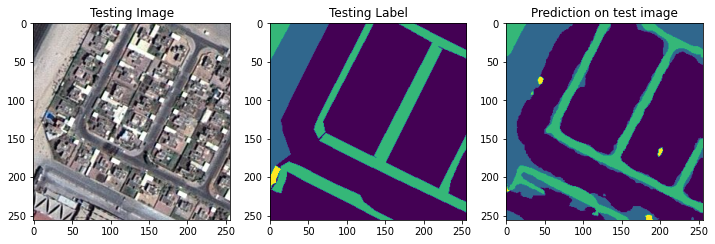

In [27]:
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:] # integer encoded


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

### Code to preprocess any given image and run it through the model

In [28]:
# cropping helper function
def prepare(path, patch_size):
    patch_dataset = []
    image = cv2.imread(path)
     # get x and y dimensions rounded to multiples of 256
    SIZE_X = (image.shape[1]//patch_size) * patch_size 
    SIZE_Y = (image.shape[0]//patch_size) * patch_size 
    image = Image.fromarray(image)

    # crop the image
    image = image.crop((0,0,SIZE_X, SIZE_Y))
    image = np.array(image)

    # Extract patches from each image
    # print("Now patchifying image", path+"/"+image_name)
    patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            
            single_patch_img = patches_img[i,j,:,:]
            
            #Use minmaxscaler instead of just dividing by 255. 
            single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
            
            #single_patch_img = (single_patch_img.astype('float32')) / 255. 
            single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.

            patch_dataset.append(single_patch_img)   
                                 
    return patch_dataset

# Plotting helper function
def plot(img_input, patch_size):
    plt.figure(figsize=(18, 6))
    plt.subplot(121)
    plt.title('Original image')
    plt.imshow(np.reshape(img_input, (patch_size, patch_size, 3)))
    
# Predicting helper function
def predict(pred_img_input):
    pred_img_input=np.expand_dims(pred_img_input, 0)
    prediction = (model.predict(pred_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:] 
    return predicted_img

# Plotting 256 by 256 predicted patches
def plotpred(img):
    plt.figure(figsize=(18,6))
    plt.subplot(121)
    plt.title('Predicted image')
    plt.imshow(img)

# helper function for counting number of building encoded pixels
def count_building_pixels(predicted_img):
    counter = 0
    for i in range(0, 256):
        for j in range(0, 256):
            if int(predicted_img[i][j]) == 1:
                counter += 1
    return counter

1/1 [==============================] - 0s 94ms/step
For patch 0: 33530/65536 pixels are building-encoded.
1/1 [==============================] - 0s 95ms/step
For patch 1: 28799/65536 pixels are building-encoded.
1/1 [==============================] - 0s 90ms/step
For patch 2: 19964/65536 pixels are building-encoded.
1/1 [==============================] - 0s 91ms/step
For patch 3: 31456/65536 pixels are building-encoded.


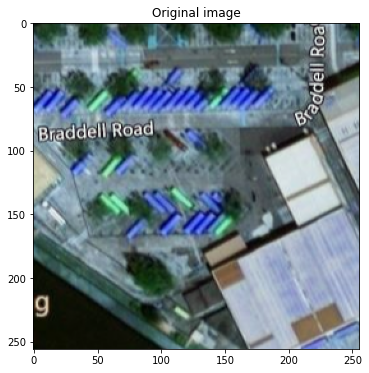

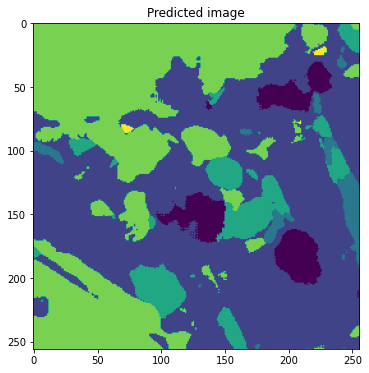

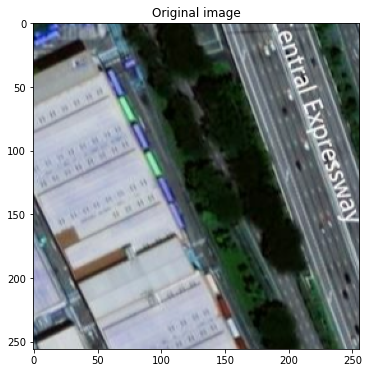

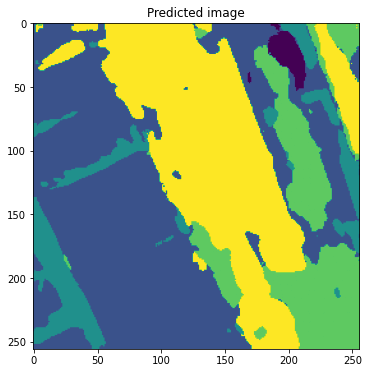

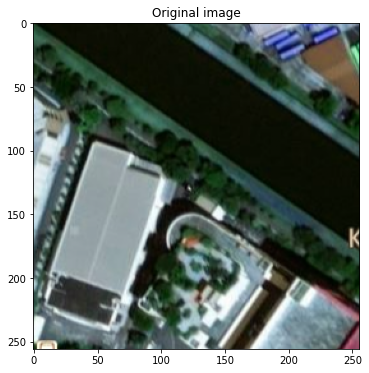

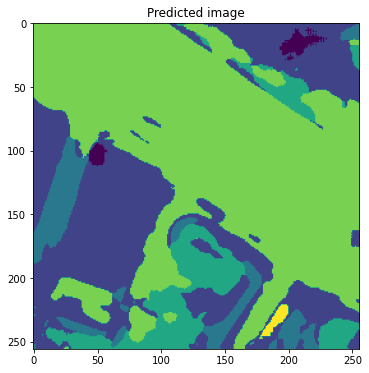

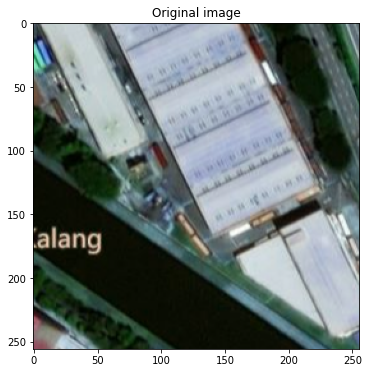

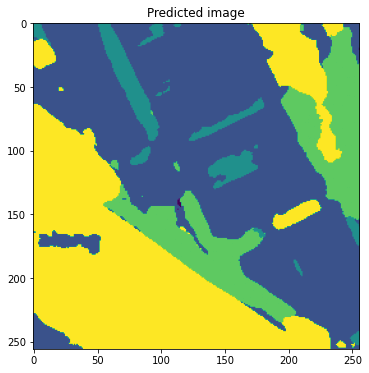

In [29]:
pred_img_input = prepare(path = "imgs\Screenshot1.png", patch_size= 256)

predicted_imgs = []
for i in range(0, len(pred_img_input)):
    # input
    plot(pred_img_input[i], 256)

    # prediction
    predicted_img = predict(pred_img_input[i])
    predicted_imgs.append(predicted_img)
    plotpred(predicted_img)

    # count pixels
    building_pixels = count_building_pixels(predicted_img)
    print("For patch " + str(i) + ": " + str(building_pixels) + "/65536 pixels are building-encoded.")